<h1> todo : </h1>
<h3>
    <ol>
        <li> figure out how to slice the model and get embedddings : 
            <ul>
                <li> lead : use model.resnet it contains all the layers except the final flatten layer and the 1000-node classification head </li>
            </ul>
        </li>
    </ol>    
</h3>

<h1> SETUP </h1>

In [1]:
import torch
import os
import cv2
import supervision as sv
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import cv2

from groundingdino.util.inference import Model

import sys

def include_utils():
    parent_directory = os.path.abspath('/app/utils')
    sys.path.append(parent_directory)

include_utils()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

from utils.model_utils import check_model_paths , get_sam_model , get_gdino_model, enhance_class_name, segment
from utils.model_utils import plot_detections, get_resnet_model
from utils.data_utils import normalize
from utils.viz_utils import viz_im_small, concise_ims_and_plots, get_bar_plot

from utils.viz_utils import viz_im_small

check_model_paths()


cuda
../bin/model_files/groundingdino_swint_ogc.pth  exists
../GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py  exists
../bin/model_files/sam_vit_h_4b8939.pth  exists


<h1> inference </h1>

In [2]:
gdino_model = get_gdino_model()
sam_model = get_sam_model()
resnet_model = get_resnet_model()

/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [4]:
SOURCE_IMAGE_PATH = "../data/images/road_traffic_1.jpg"
CLASSES = ['car', 'building', 'traffic light', 'road sign', 'person', 'train']
BOX_TRESHOLD = 0.40
TEXT_TRESHOLD = 0.25

image = cv2.imread(SOURCE_IMAGE_PATH)

print(f"image shape : {image.shape}")
# detect objects
detections = gdino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_model,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)


plot_detections(image,
                detections,
                sam_model,
                CLASSES)

image shape : (800, 1200, 3)


/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py:885: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


TypeError: 'SamPredictor' object is not subscriptable

detections.masks

<h1> RESNET EMBEDDINGS </h1>

In [ ]:

from utils.model_utils import check_model_paths , get_sam_model , get_gdino_model, enhance_class_name, segment
from utils.model_utils import plot_detections, get_resnet_model
from utils.data_utils import normalize
from utils.viz_utils import viz_im_small, concise_ims_and_plots, get_bar_plot
from utils.distance_utils import get_k_nearest

ModuleNotFoundError: No module named 'viz_utils'

In [ ]:
from IPython.display import Image as im 
from IPython.display import display as dis 
import glob 
import torch
import cv2
import matplotlib.pyplot as plt



testim_paths = glob.glob("../data/images/embedding_tester/*")

embedding_dict = dict()
input_dict = dict()

plotter = concise_ims_and_plots(xdim = 15, ydim = 15)


with torch.no_grad():
    global_object_id = 0
    for ind, i in enumerate(testim_paths):
        predicted_label = resnet_model.predict(cv2.imread(i), return_embedding = False)
        print(f"\nPREDICTED CLASS : {predicted_label}\n")

        embedding = resnet_model.predict(cv2.imread(i), return_embedding = True)
        print(f"final embedding shape : {embedding.shape}")

        object_id = f"{predicted_label}_" + str(global_object_id)
        object_id = f"{predicted_label}_" + str(global_object_id)

        embedding_dict[object_id] = embedding.detach().cpu().numpy()
        input_dict[object_id] = cv2.imread(i)
        
        plotter.add_plot_data(cv2.imread(i), '')
        
        norm = np.linalg.norm(embedding)
        viz_embedding = embedding / norm
        # viz_embedding = normalize(embedding) 
        plotter.add_plot_data(get_bar_plot(viz_embedding), f'embedding : {predicted_label}')

        global_object_id+=1

plotter.viz_plot_data("emebddings visualization", mode = 'square')

NameError: name 'concise_ims_and_plots' is not defined

In [ ]:

embedding_names = np.array(list(embedding_dict.keys()))
embedding_matrix = np.array(list(embedding_dict.values()))
input_masked_crops  = np.array(list(input_dict.values()))

norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)

norms

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[5.32726  ],
       [5.713146 ],
       [5.8844204],
       [6.9684544],
       [6.6761403],
       [5.7203965],
       [5.0550194],
       [5.561364 ],
       [5.73817  ]], dtype=float32)

In [ ]:


def get_k_nearest(embedding_matrix, image_array, class_names, k):
    # embedding_names = np.array(list(embedding_dict.keys()))
    # embedding_matrix = np.array(list(embedding_dict.values()))
    # input_masked_crops  = np.array(list(input_dict.values()))

    norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
    print(norms)
    normalized_embeddings = embedding_matrix / norms

    cosine_similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
    
    cosine_similarity_matrix -= np.eye(embedding_matrix.shape[0]) * cosine_similarity_matrix.max()

    neighbour_inds = (cosine_similarity_matrix).argsort(axis =  1)[:, -k:]

    return class_names[neighbour_inds], image_array[neighbour_inds]

[[5.32726  ]
 [5.713146 ]
 [5.8844204]
 [6.9684544]
 [6.6761403]
 [5.7203965]
 [5.0550194]
 [5.561364 ]
 [5.73817  ]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


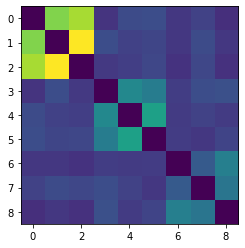

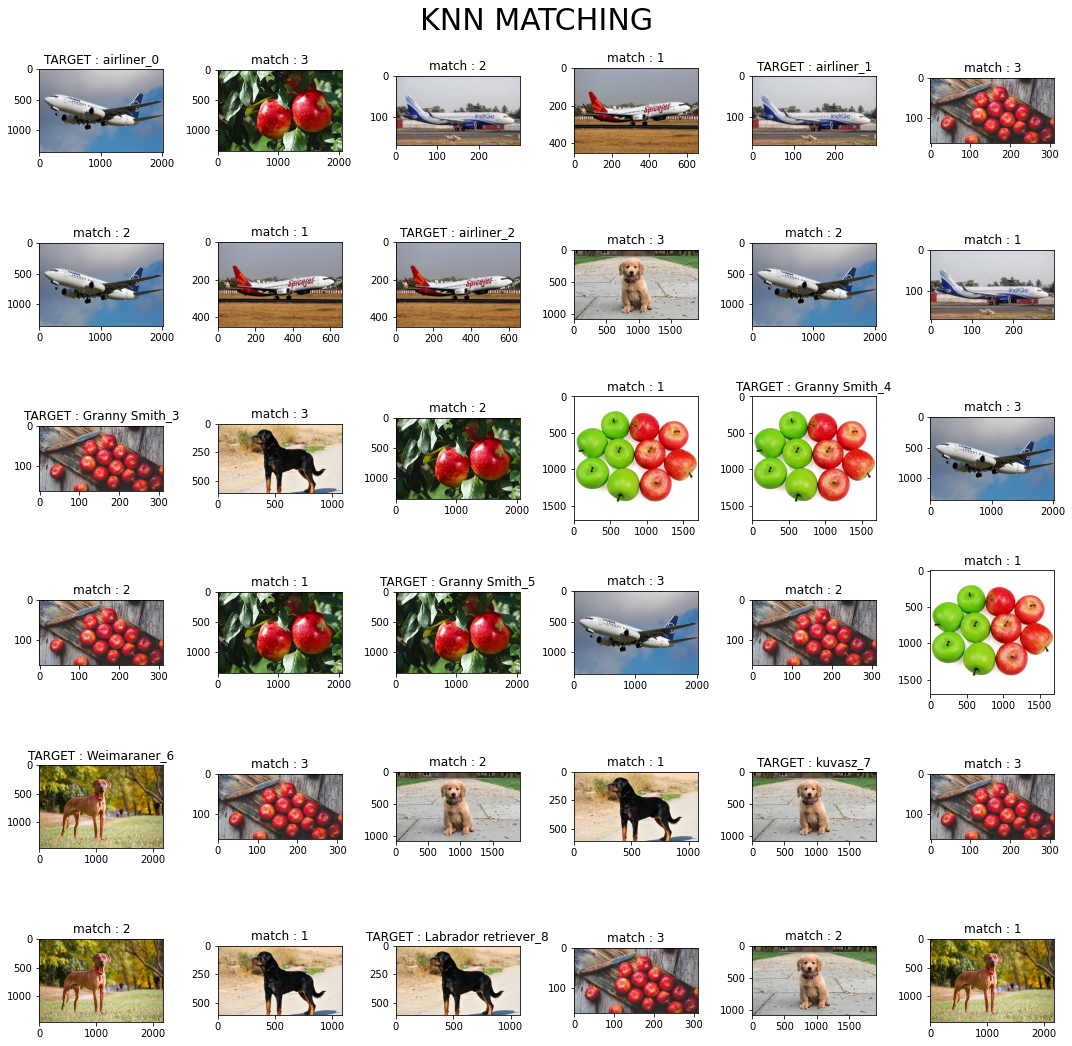

In [ ]:

embedding_names = np.array(list(embedding_dict.keys()))
embedding_matrix = np.array(list(embedding_dict.values()))
input_masked_crops  = np.array(list(input_dict.values()))

nn_embeddings, nn_masks = get_k_nearest(embedding_dict, input_dict, k)

plotter = concise_ims_and_plots()

for ind, (label, masked_crop) in enumerate(input_dict.items()):

    plotter.add_plot_data(masked_crop, f"TARGET : {label}")

    for j in range(k):     
        tempim = cv2.resize(nn_masks[ind, j].astype(float), (100,100))

        plotter.add_plot_data(normalize(nn_masks[ind, j].astype(float)), f"match : {3-j}")
        
plotter.viz_plot_data("KNN MATCHING")

<h1> Resnet prediction on Masks </h1>

['/app/data/images/embedding_tester/aeroplane.jpg', '/app/data/images/embedding_tester/aeroplane_2.jpg', '/app/data/images/embedding_tester/aeroplane_3.jpg', '/app/data/images/embedding_tester/apple_1.jpeg', '/app/data/images/embedding_tester/apple_2.jpg', '/app/data/images/embedding_tester/apple_3.jpg', '/app/data/images/embedding_tester/dog_1.jpg', '/app/data/images/embedding_tester/dog_2.jpg', '/app/data/images/embedding_tester/dog_3.jpg']

classes : ['apple', 'aeroplane', 'dog']



/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py:885: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning
/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


results : 
 apple : 1
aeroplane : 1


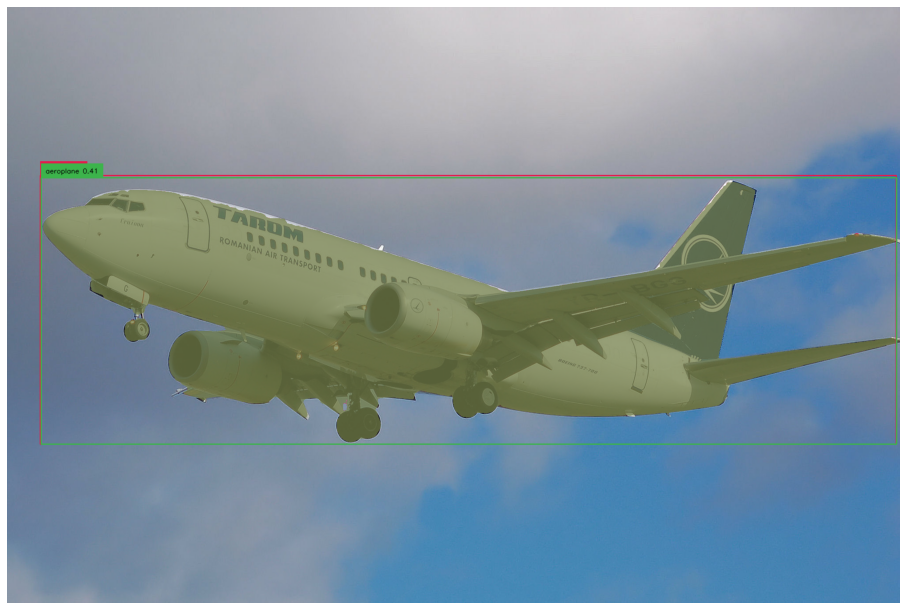

results : 
 aeroplane : 1


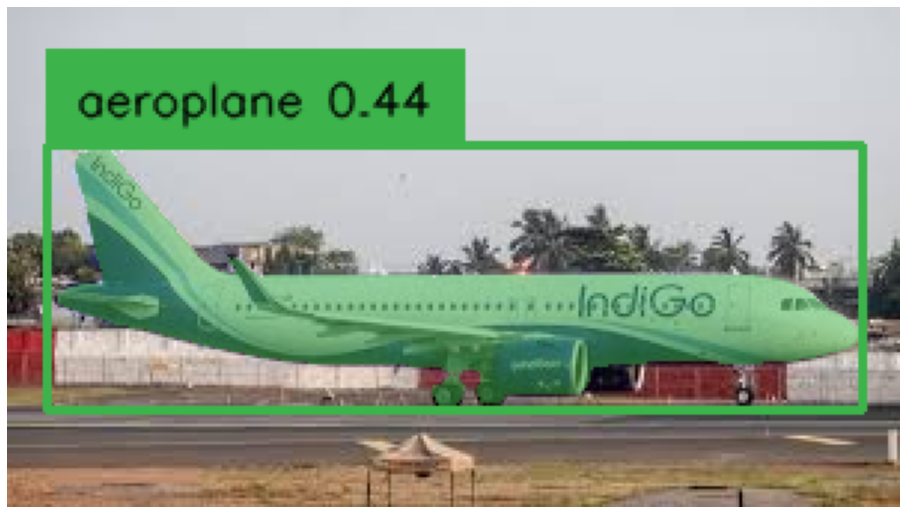

results : 
 aeroplane : 1


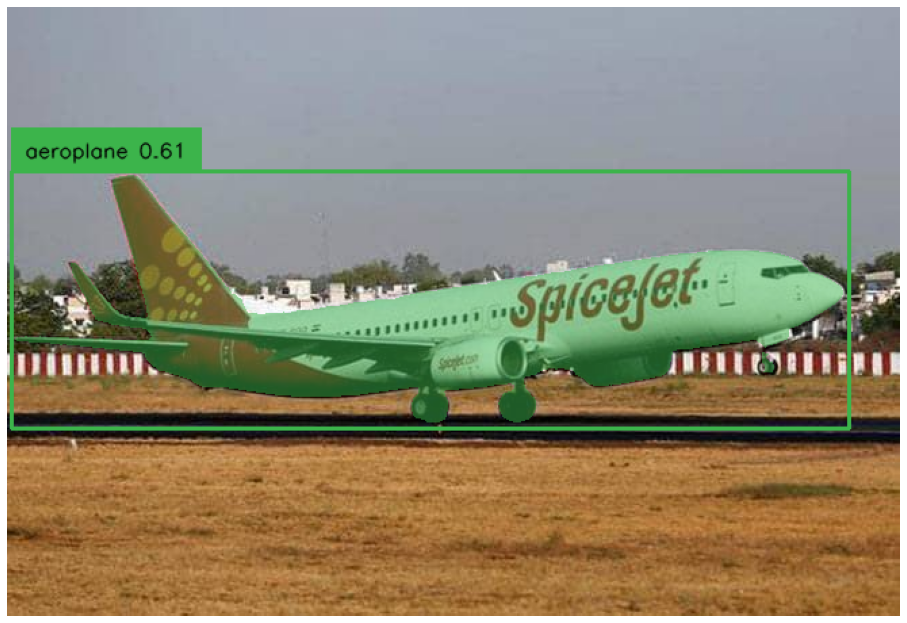

results : 
 apple : 1


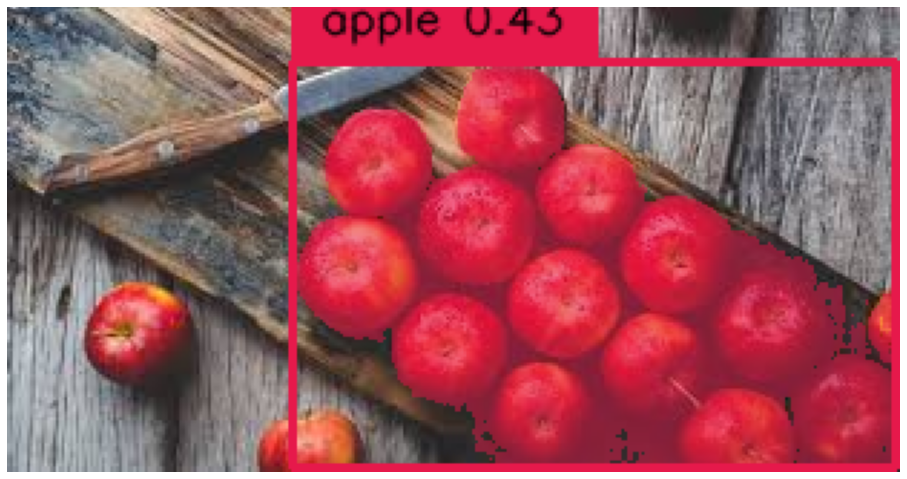

results : 
 apple : 10


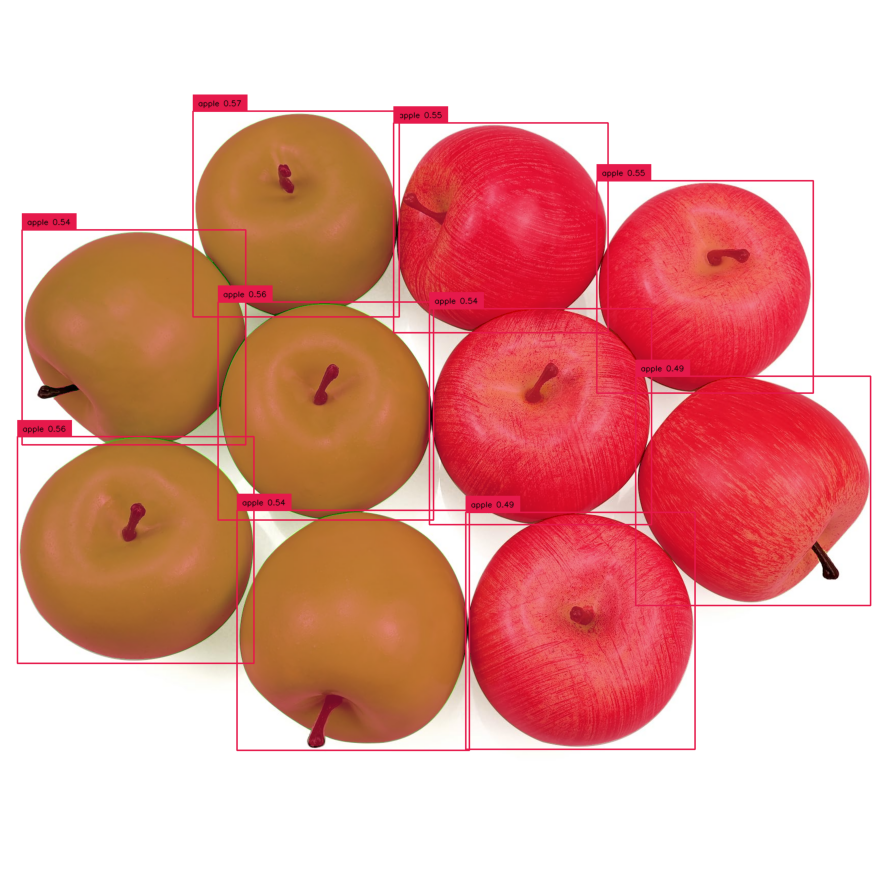

In [3]:
import os
from utils.model_utils import object_embedder

test_class = object_embedder(segmentor = sam_model,
                             detector = gdino_model,
                             embeddor = resnet_model)

dir_path = "/app/data/images/embedding_tester/"
image_paths = [os.path.join(dir_path, im_path) for im_path in os.listdir(dir_path)]
print(image_paths)
classes = ["apple", "aeroplane", "dog"]

test_class.detect_objects(image_paths, classes, viz_outputs = True)
# test_class.detect_objects(["/app/data/images/road_traffic_1.jpg"], classes, viz_outputs = True)


image shape : (800, 1200, 3)
detections type : <class 'numpy.ndarray'>
detections shape : (13, 800, 1200)


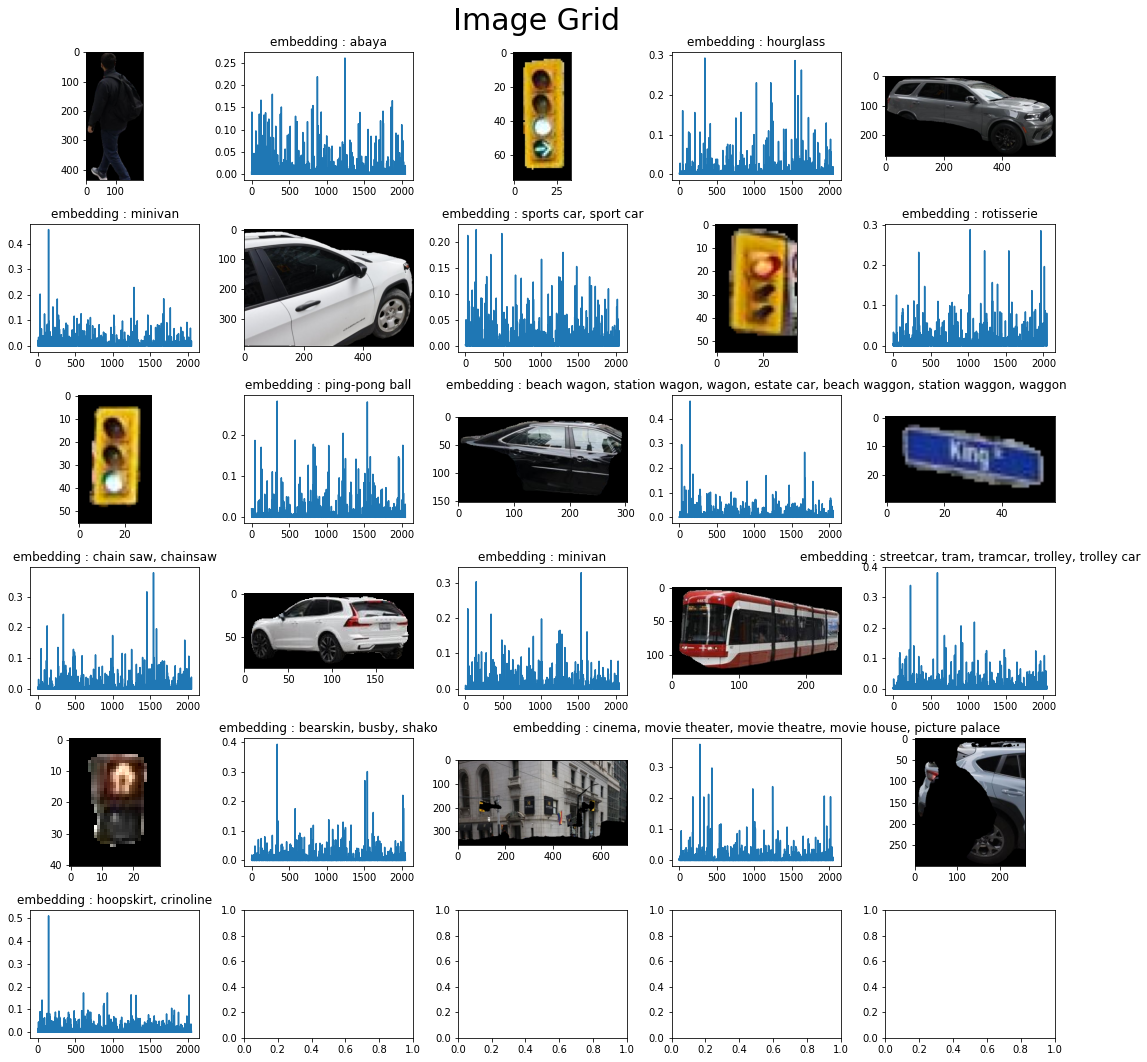

In [128]:
from IPython.display import Image as im 
from IPython.display import display as dis 

print(f"image shape : {image.shape}")
print(f"detections type : {type(detections.mask)}")
print(f"detections shape : {detections.mask.shape}")
masks = detections.mask
masks = masks.astype(int)

embedding_dict = dict()
input_dict = dict()

plotter = concise_ims_and_plots(15,15)

with torch.no_grad():
    global_object_id = 0
    for i in range(len(masks)):

        masked_image = image * np.concatenate([masks[i][..., None],
                    masks[i][..., None],
                    masks[i][..., None]], axis = 2)
    
        ymin, xmin, ymax, xmax = detections.xyxy[i].astype(int)
        masked_image = masked_image[xmin:xmax, ymin:ymax, :]

        predicted_label = resnet_model.predict(masked_image, return_embedding = False)
        
        plotter.add_plot_data(masked_image, "")
            
        embedding = resnet_model.predict(masked_image, return_embedding = True)
        
        norm = np.linalg.norm(embedding.detach().cpu().numpy())
        viz_embedding = embedding / norm
        plotter.add_plot_data(get_bar_plot(viz_embedding.detach().cpu().numpy()), f'embedding : {predicted_label}')

        object_id = f"{predicted_label}_" + str(global_object_id)
        embedding_dict[object_id] = embedding.detach().cpu().numpy()
        input_dict[object_id] = masked_image

plotter.viz_plot_data()

In [ ]:

k = 3
nn_embeddings, nn_masks = get_k_nearest(embedding_dict, input_dict, k)



    
# for ind, (label, masked_crop) in enumerate(input_dict.items()):
#     print(f"\ncurrent image : {label}\n")
    
#     print(f"masked crop type : {type(masked_crop)}, masked_crop shape : {masked_crop.shape}")
#     cv2.imwrite("temp.jpg", masked_crop)
#     dis(im("temp.jpg"))

#     print(f"neigbours of : {label}")
#     print(nn_embeddings[ind])
#     # for j in range(k):     
#     #     tempim = cv2.resize(nn_masks[ind, j].astype(float), (100,100))
#     #     cv2.imwrite("temp.jpg", tempim)
#     #     dis(im("temp.jpg"))



    


In [ ]:
with torch.no_grad():
    i = 2
    masked_image = image * np.concatenate([masks[i][..., None],
                    masks[i][..., None],
                    masks[i][..., None]], axis = 2)

    ymin, xmin, ymax, xmax = detections.xyxy[i].astype(int)
    print(f"xmin : {xmin}, ymin : {ymin}, xmax : {xmax}, ymax {ymax}")
    print(f"masked image crop shape ; {masked_image[xmin:xmax, ymin:ymax, :].shape}")
    masked_image = masked_image[xmin:xmax, ymin:ymax, :]
    cv2.imwrite("temp.jpg", masked_image)
    dis(im("temp.jpg"))

    #   RESNET PREDICTION 
    inputs = processor(masked_image, return_tensors="pt")
    logits = model(**inputs).logits
    predicted_label = logits.argmax(-1).item()
    print(f"\nPREDICTED CLASS : {model.config.id2label[predicted_label]}\n")

    #   RESNET EMBEDDINGS
    embedding = model.resnet(**inputs)[1]
    embedding = model.classifier[0](embedding)
    print(f"final embedding shape : {embedding.shape}")